In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate 

import sympy

import surfinBH

## Testing surfinBH

In [2]:
#Pick the fit
fitOpt = list(surfinBH.fits_collection.keys())
print(fitOpt)

[surfinBH.fits_collection[fit].desc for fit in fitOpt]

['NRSur3dq8Remnant', 'surfinBH7dq2', 'NRSur7dq4Remnant']


['Fits for remnant mass, spin and kick veclocity for nonprecessing BBH systems. This model was called surfinBH3dq8 in the paper.',
 'Fits for remnant mass, spin and kick veclocity for generically precessing BBH systems.',
 'Fits for remnant mass, spin and kick veclocity for generically precessing BBH systems up to mass ratio 4.']

In [3]:
fit = surfinBH.LoadFits('NRSur7dq4Remnant')
help(fit)

Loaded NRSur7dq4Remnant fit.
Help on Fit7dq4 in module surfinBH._fit_evaluators.fit_7dq4 object:

class Fit7dq4(surfinBH.surfinBH.SurFinBH)
 |  Fit7dq4(name, load_nrsur=False)
 |  
 |  A class for the NRSur7dq4Remnant model presented in Varma et al.,
 |  arxiv:1905.09300, hereafter referred to as THE PAPER.
 |  
 |  This model predicts the final mass mf, final spin vector
 |  chif and final kick velocity vector vf, for the remnants of precessing
 |  binary black hole systems.  The fits are done using Gaussian Process
 |  Regression (GPR) and also provide an error estimate along with the fit
 |  value.
 |  
 |  This model has been trained in the parameter space:
 |      q <= 4, |chiA| <= 0.8, |chiB| <= 0.8
 |  
 |  However, it extrapolates reasonably to:
 |      q <= 6, |chiA| <= 1, |chiB| <= 1
 |  
 |  =========================================================================
 |  Usage:
 |  
 |  import surfinBH
 |  
 |  # Load the fit
 |  fit = surfinBH.LoadFits('NRSur7dq4Remnant')
 |  

In [4]:
q = 1
chiA = [0.8,0,0]
chiB = [0.8,0,0]
mf,chif,vf,_,_,_ = fit.all(1,chiA,chiB)
print(f'Final Mass: {mf}')
print(f'Final Spin: {chif}')
print(f'Final Velocity: {vf}')

Final Mass: 0.9497928379066933
Final Spin: [0.28586015 0.04535385 0.70762916]
Final Velocity: [-9.39668527e-05 -2.12472083e-05 -2.87053238e-05]


In [5]:
np.sort([1,2,5,3])[::-1]

array([5, 3, 2, 1])

## Turning a PDF into an easy to sample random variable transform
#### Inverse transform sampling

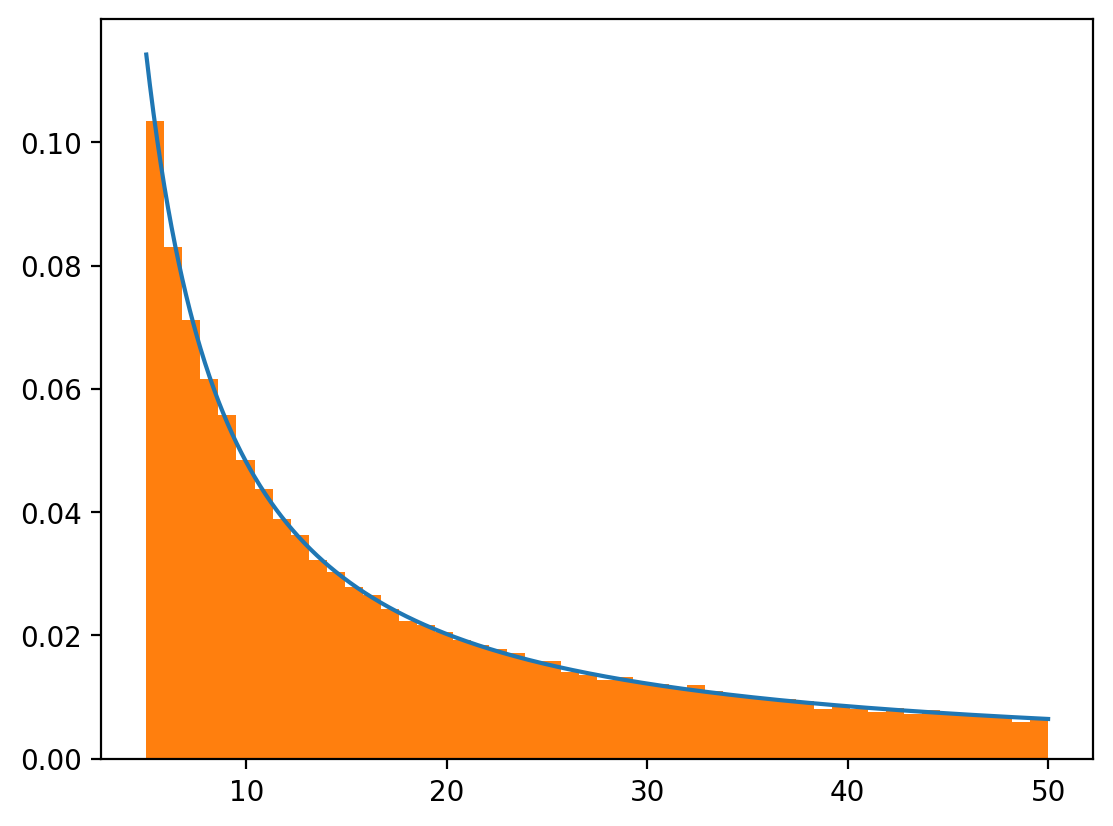

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import sympy

m = sympy.Symbol('m')
p = sympy.Symbol('p')
func = m**(-1.25)
norm = sympy.integrate(func, (m, 5, 50))
pdf = (1/norm)*m**(-1.25)


cdf = sympy.integrate(pdf,(m,5,m))

quantile = sympy.solvers.solve(cdf-p,m)

#pdf = sympy.lambdify(m,pdf)
#cdf = sympy.lambdify(m,cdf)
quantile = sympy.lambdify(p,quantile)

plt.plot(np.linspace(5,50,1000),pdf(np.linspace(5,50,1000)))

u = np.random.random(100000)
mdist = quantile(u)
plt.hist(mdist,bins=50,density=True)
plt.show()

In [35]:
m = sympy.Symbol('m',positive=True)
p = sympy.Symbol('p',positive=True)

func = m**(-(1.35))

norm = sympy.integrate(func, (m, 5, 50))
        
pdf = (1/norm)*m**(-(1.35))

cdf = sympy.integrate(pdf,(m,5,m))

        
quantile = sympy.solve(cdf-p,m)
try:
    quantile = sympy.lambdify(p,quantile[0])
except:
    quantile = sympy.lambdify(p,quantile)
print(quantile(0.01))

5.079896318680909


## Black hole object making!

In [108]:
test = {'a':0,'b':0}
allkeys = ['a','b','c','d']
[k for k in allkeys if k not in test.keys()]
test.update({'c':0})
print(test)

{'a': 0, 'b': 0, 'c': 0}


In [36]:
import sys
sys.path.append('.')
from BBH_kick_sim import Simulator

In [105]:
params = {'cluster_mass':1e6}
test = Simulator.Simulator(params)

'cluster_radius' not set, defaulting to 1000000.0
'imf_alpha' not set, defaulting to 2.25
'min_bh_star' not set, defaulting to 10
'bh_mass_frac' not set, defaulting to 0.5
'min_star' not set, defaulting to 0.8
'max_star' not set, defaulting to 100
'sbh_fitter' not set, defaulting to NRSur7dq4Remnant
'vel_thresh' not set, defaulting to 1
Setting up analytic mass distribution. This may take a while depending on your imf alpha
Done
Loaded NRSur7dq4Remnant fit.
Setup complete, Globular Cluster now has 14321 black holes.


In [106]:
test.begin_sim()

No stop time specified, Running until 1 or 0 black holes remain
13321/14321 remaining
12321/14321 remaining
11321/14321 remaining
10321/14321 remaining
9321/14321 remaining
8321/14321 remaining
7321/14321 remaining
6321/14321 remaining
5321/14321 remaining
4321/14321 remaining
3321/14321 remaining
2321/14321 remaining
1321/14321 remaining
321/14321 remaining
Finished. Total Simulation time: 99.99999492855956
Total CPU time: 5.389098882675171
